# Statistical model comparison

In this notebook you will compare two models A and B. We will check that model A is better than B, or not.

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt

# Load MAGIC Data Set

<center><img src="https://github.com/HSE-LAMBDA/ML-IDS/blob/main/course_1/4_topic/4_statistical_model_comparison/img/magic1.png?raw=1" width="1000"></center>

Source: https://magic.mpp.mpg.de/

In [33]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

--2021-11-24 15:14:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1.4M) [application/x-httpd-php]
Saving to: ‘magic04.data.3’

magic04.data.3      100%[===================>]   1.41M  3.87MB/s    in 0.4s    

2021-11-24 15:14:39 (3.87 MB/s) - ‘magic04.data.3’ saved [1477391/1477391]



Features description:
- **Length:** continuous # major axis of ellipse [mm]
- **Width:** continuous # minor axis of ellipse [mm]
- **Size:** continuous # 10-log of sum of content of all pixels [in #phot]
- **Conc:** continuous # ratio of sum of two highest pixels over fSize [ratio]
- **Conc1:** continuous # ratio of highest pixel over fSize [ratio]
- **Asym:** continuous # distance from highest pixel to center, projected onto major axis [mm]
- **M3Long:** continuous # 3rd root of third moment along major axis [mm]
- **M3Trans:** continuous # 3rd root of third moment along minor axis [mm]
- **Alpha:** continuous # angle of major axis with vector to origin [deg]
- **Dist:** continuous # distance from origin to center of ellipse [mm]
- **Label:** g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 \
h = hadron (background): 6688

In [34]:
f_names = np.array(["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist"])

data = pd.read_csv("magic04.data", header=None, names=list(f_names)+["Label"])
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Data preparation

In [35]:
# prepare a matrix of input features
X = data[f_names].values

# prepare a vector of true labels
y = 1 * (data['Label'].values == "g")

# take only 10% of the data for speed up
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=11)

In [37]:
# print sizes of X and y
X.shape, y.shape

((1902, 10), (1902,))

In [36]:
X[:2]

array([[ 2.367940e+01,  1.275260e+01,  2.658300e+00,  5.659000e-01,
         3.373000e-01,  3.284470e+01,  2.519930e+01, -1.155520e+01,
         4.183400e+01,  2.317678e+02],
       [ 2.947580e+01,  1.964590e+01,  2.647900e+00,  3.240000e-01,
         1.631000e-01, -1.755600e+01, -2.284400e+01, -1.723510e+01,
         3.368500e+01,  1.123060e+02]])

In [38]:
y[:5]

array([0, 1, 0, 0, 0])

# Preprocessing

Scale input data using StandardScaler:
$$
X_{new} = \frac{X - \mu}{\sigma}
$$

In [39]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Create object of the class and set up its parameters
ss = StandardScaler()

# Estimate mean and sigma values
ss.fit(X)

# Scale the sample
X = ss.transform(X)

# Define models A and B


We will compare two models: A and B. Model A will have 12 hidden neurons, and model B - only 10. We would like to check that A is better than B.

In [40]:
!pip install pytorch-lightning 

In [41]:
import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl

class Model(pl.LightningModule):

    def __init__(self, n_neurons=10):
        super().__init__()
        
        # define all layers of the netwrok
        self.net = nn.Sequential(
                                nn.Linear(10, n_neurons), 
                                nn.Tanh(), 
                                nn.Linear(n_neurons, 1), 
                                nn.Sigmoid())

    
    def forward(self, x):
        # make a prediction for x
        return self.net(x)

    # calculate loss function values
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        return loss

    # define optimizer to fit the network
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [42]:
model_A = Model(n_neurons=12)
model_A

Model(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [43]:
model_B = Model(n_neurons=10)
model_B

Model(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# Data loader creation

We will define a helping function for converting `X_train` and `y_train` into PyTorch `DataLoader`.

In [44]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(X_train, y_train, batch_size=128):
    # combine X and y into one pytorch tensor dataset
    dataset_train = TensorDataset(torch.tensor(X_train, dtype=torch.float), 
                                  torch.tensor(y_train.reshape(-1, 1), dtype=torch.float))
    # loader divides our train data into batches
    train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4)
    return train_loader

In [45]:
# example of usage
create_data_loader(X[:5], y[:5], 1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Quality metrics

We will use ROC AUC as a target quality metrics for our models.

In [46]:
from sklearn import metrics

# example of usage
metrics.roc_auc_score(y_true=[0, 0, 1, 1], 
                      y_score=[0.1, 0.6, 0.8, 0.9])

1.0

# Fit models


**Algorithm:**
- Given two models A and B
- Given sample X, y
- For i=1, …, k do:
    - Randomly split $X$ and $y$ into train and test samples
    - Fit models A and B on the train sample
    - Compute quality metrics $q_{Ai}$ and $q_{Bi}$ for the models on the test sample
    - Calculate the difference $q_i = q_{Ai} - q_{Bi}$

Result: we have *k* quality metric differences $\{q_1, q_2, ..., q_k \}$

# Task 1
Using the algorithm above fit models A and B, calculate ROC AUCs for them and estimate the differences q. 

**Hint:** use `n_neurons=10` for model B. Use `model(torch.tensor(X_test, dtype=torch.float))[:, 0].detach().numpy()` to make predictions for a model.

In [47]:
n_iterations = 50
    
q_A = []
q_B = []
from sklearn.metrics import roc_auc_score
# go through each iteration of KFold
for it in range(n_iterations):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
    
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_train)
    y_test = torch.FloatTensor(y_train)

    # create pytorch dataloader
    train_loader = create_data_loader(X_train, y_train, batch_size=128)
    
    # init model and trainer for A
    model_A = Model(n_neurons=12)
    trainer_A = pl.Trainer(max_epochs=10, weights_summary=None, progress_bar_refresh_rate=0)

    trainer_A.fit(model_A, train_loader)
    logits_A = model_A(X_train)
    y_test_proba_A = model_A(torch.tensor(X_test, dtype=torch.float))[:, 0].detach().numpy()
    y_test_pred_A  = 1 * (y_test_proba_A > 0.5)
    auc_A = roc_auc_score(y_test, y_test_pred_A)

    ### BEGIN SOLUTION
    model_B = Model(n_neurons=10)
    trainer_B = pl.Trainer(max_epochs=10, weights_summary=None, progress_bar_refresh_rate=0)

    trainer_B.fit(model_B, train_loader)
    logits_B = model_B(X_train)
    y_test_proba_B = model_B(torch.tensor(X_test, dtype=torch.float))[:, 0].detach().numpy()
    y_test_pred_B  = 1 * (y_test_proba_B > 0.5)
    auc_B = roc_auc_score(y_test, y_test_pred_B)
    ### END SOLUTION
    
    q_A.append(auc_A)
    q_B.append(auc_B)
    
q = np.array(q_A) - np.array(q_B)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/

In [48]:
print("Mean value of q: ", q.mean())

Mean value of q:  0.0047760268032511054


Expected approximate output:

<center>   
    
```python
Mean value of q: 0.00312
``` 
    
</center>

In [49]:
### BEGIN HIDDEN TESTS
actual  = np.array([q.mean()])
desired = np.array([0.003])
np_testing.assert_allclose(actual, desired, atol=0.001)
### END HIDDEN TESTS

AssertionError: ignored

In [ ]:
q

# Hypotheses test

We want to test the following hypotheses:
$$
H_0: A = B
$$

$$
H_1: A \text{ is better than } B
$$

We will test them using the bootstrap method.

<center><img src="https://github.com/HSE-LAMBDA/ML-IDS/blob/main/course_1/4_topic/4_statistical_model_comparison/img/bootstrap.png?raw=1" width="600"></center>

**Algorithm:**
- For j=1, …, m do:
    - (Bootstrap) Sample with **replacement** a subsample with k objects from $\{q_1, q_2, ..., q_k \}$
    - Calculate mean value $\bar{q}_j$ for the bootstrap sample
- Result: we have m means of the differences $\{\bar{q}_1, \bar{q}_2, ..., \bar{q}_m \}$
- Estimate the probability P that model A is better than model B. This equals to the probability $P$ that $\bar{q}_i > 0$:

# Task 2
Using the algorithm above to estimate means of the differences $\{\bar{q}_1, \bar{q}_2, ..., \bar{q}_m \}$. 

**Hint:** use `resample(q, replace=True, n_samples=len(q))` to make bootstrap samples.

In [59]:
from sklearn.utils import resample

n_iterations = 1000

q_means = []

# go through each iteration of KFold
for it in range(n_iterations):
    
    ### BEGIN SOLUTION
    boot_q = resample(q, replace=True, n_samples=len(q))
    q_means = boot_q.mean()
    ### END HIDDEN TESTS
    
q_means = np.array(q_means)

In [60]:
print("Mean value of q_mean: ", q_means.mean())

Mean value of q_mean:  0.003770643794702944


Expected approximate output:

<center>   
    
```python
Mean value of q_mean: 0.00312
``` 
    
</center>

In [56]:
### BEGIN HIDDEN TESTS
P = len(q_means[q_means > 0]) / len(q_means)
actual  = np.array([P])
desired = np.array([0.997])
np_testing.assert_allclose(actual, desired, atol=0.05)
### END HIDDEN TESTS

AssertionError: ignored

# Probability that model A is better than model B

$$
P=\frac{1}{k} \sum_{i=1}^{k}I[\bar{q}_i >0]
$$

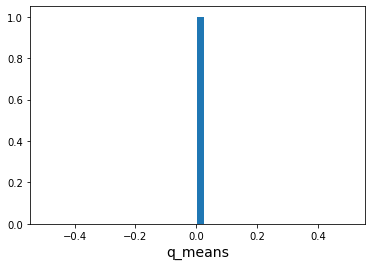

In [61]:
plt.hist(q_means, bins=50)
plt.xlabel("q_means", size=14)
plt.show()

In [62]:
q_means = np.arange(q_means)
P = len(q_means[q_means > 0]) / len(q_means)

print("Probability that model A is better than model B: ", P)

Probability that model A is better than model B:  0.0


In [63]:
alpha = 0.05

if P > 1 - alpha:
    print("A is better than B with significance level ", alpha)
else:
    print("We can not say that A is better than B")

We can not say that A is better than B
